# Support Vector Regression (SVR) on Servo Dataset

This notebook implements SVR on the servo dataset which contains data about a servo system. The task is to predict the rise time of the servo mechanism based on two continuous gain settings and two discrete mechanical linkage choices.


## 1. Import Required Libraries

First, let's import all the necessary libraries for data loading, preprocessing, modeling, and visualization.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow

np.random.seed(42)

plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

## 2. Load and Explore the Dataset

Let's load the servo dataset and explore its structure.


In [3]:
column_names = ['motor', 'screw', 'pgain', 'vgain', 'class']

try:
    df = pd.read_csv('data/servo.data', header=None, names=column_names)
except FileNotFoundError:
    df = pd.read_csv('../data/servo.data', header=None, names=column_names)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (167, 5)


,motor,screw,pgain,vgain,class
0,E,E,5,4,0.281251
1,B,D,6,5,0.506252
2,D,D,4,3,0.356251
3,B,A,3,2,5.500033
4,D,B,6,5,0.356251


In [4]:
df.describe(include='all')

,motor,screw,pgain,vgain,class
count,167,167,167.000000,167.000000,167.000000
unique,5,5,NaN,NaN,NaN
top,C,A,NaN,NaN,NaN
freq,40,42,NaN,NaN,NaN
mean,NaN,NaN,4.155689,2.538922,1.389708
std,NaN,NaN,1.017770,1.369850,1.559635
min,NaN,NaN,3.000000,1.000000,0.131250
25%,NaN,NaN,3.000000,1.000000,0.503126
50%,NaN,NaN,4.000000,2.000000,0.731254
75%,NaN,NaN,5.000000,4.000000,1.259369


In [5]:
print("Missing values:")
df.isnull().sum()

Missing values:


motor    0
screw    0
pgain    0
vgain    0
class    0
dtype: int64

## 3. Exploratory Data Analysis

Let's visualize the data to better understand the relationships between features and the target variable.


c:\Users\Bilal\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


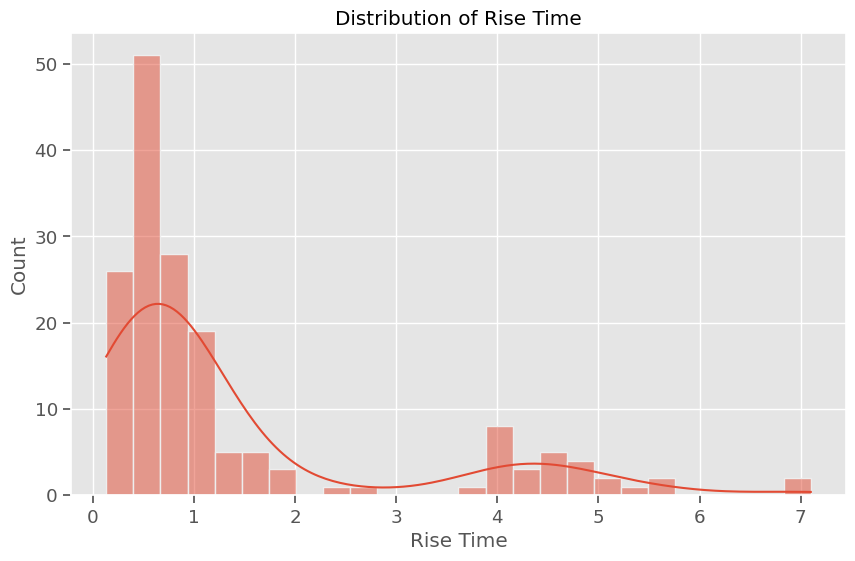

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['class'], kde=True)
plt.title('Distribution of Rise Time')
plt.xlabel('Rise Time')
plt.show()

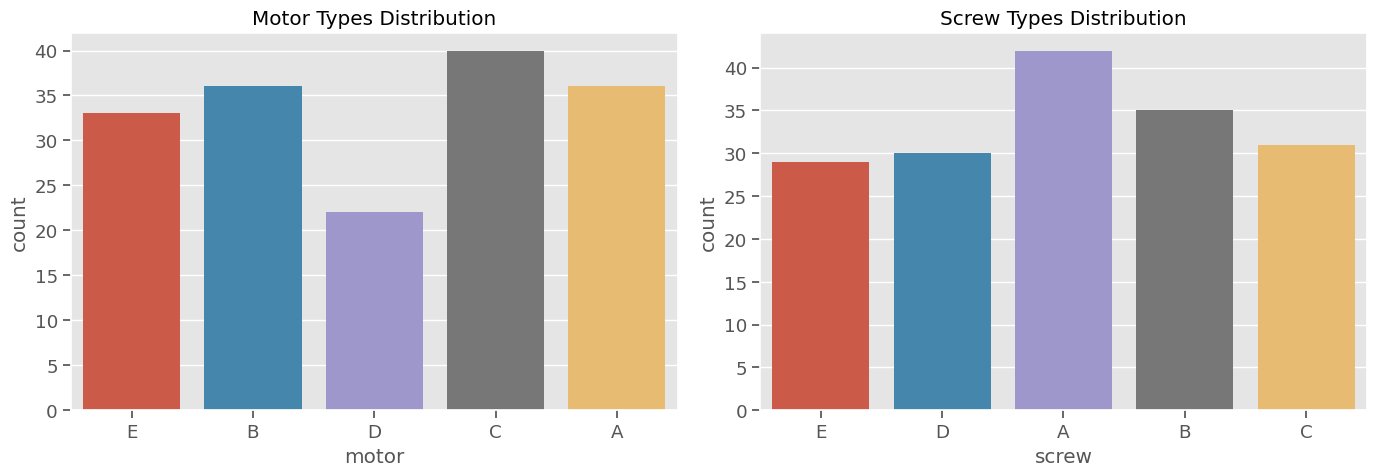

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x='motor', data=df, ax=axes[0])
axes[0].set_title('Motor Types Distribution')
sns.countplot(x='screw', data=df, ax=axes[1])
axes[1].set_title('Screw Types Distribution')
plt.tight_layout()
plt.show()

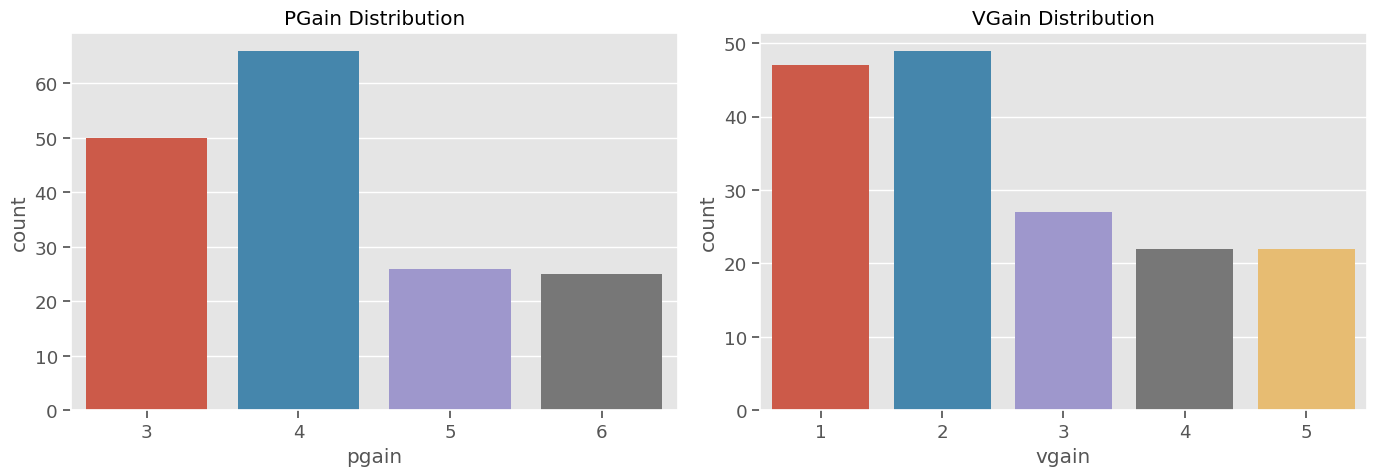

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x='pgain', data=df, ax=axes[0])
axes[0].set_title('PGain Distribution')
sns.countplot(x='vgain', data=df, ax=axes[1])
axes[1].set_title('VGain Distribution')
plt.tight_layout()
plt.show()

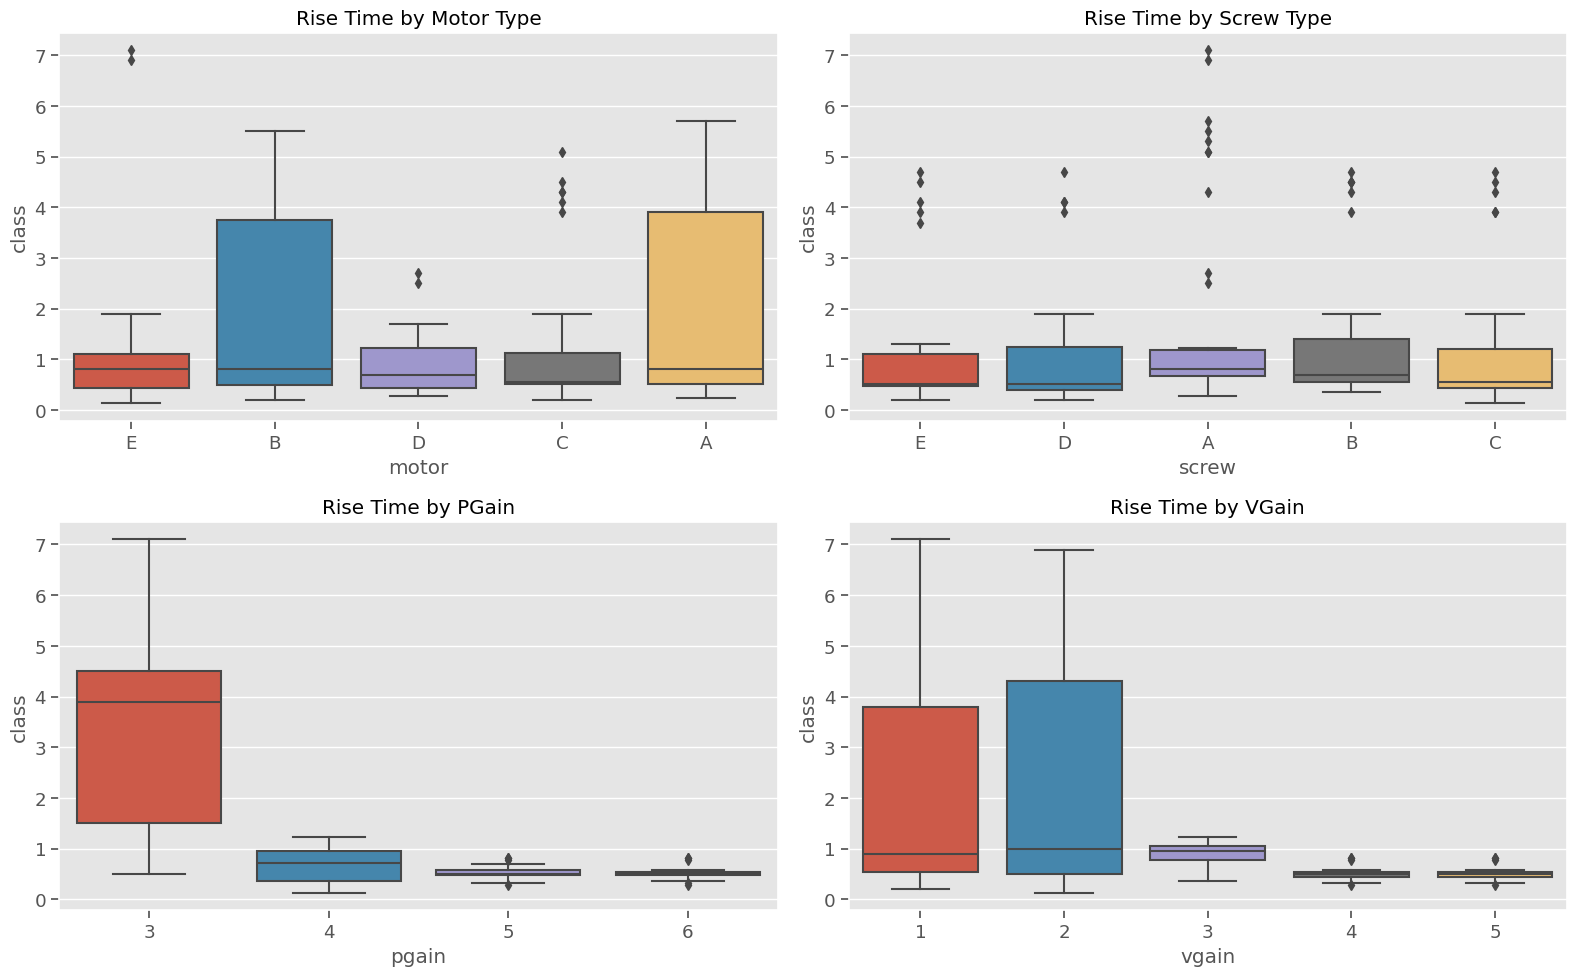

In [9]:
# Boxplot: Target value by categorical variables
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.boxplot(x='motor', y='class', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Rise Time by Motor Type')
sns.boxplot(x='screw', y='class', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Rise Time by Screw Type')
sns.boxplot(x='pgain', y='class', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Rise Time by PGain')
sns.boxplot(x='vgain', y='class', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Rise Time by VGain')
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

Now let's preprocess the data for modeling. We need to handle the categorical variables using one-hot encoding.


In [10]:
X = df.drop('class', axis=1)
y = df['class']

categorical_cols = ['motor', 'screw']
numerical_cols = ['pgain', 'vgain']

X['pgain'] = pd.to_numeric(X['pgain'])
X['vgain'] = pd.to_numeric(X['vgain'])

split features to categorical and numerical


In [11]:
num_features = df.select_dtypes(include=np.number).columns.drop('class').tolist()
cat_features = df.select_dtypes(exclude=np.number).columns.tolist()


In [12]:
# scaler = StandardScaler()

# features = df[num_features]
# scaled_features = scaler.fit_transform(features)

# data = pd.DataFrame(scaled_features, columns=num_features)
# data = pd.concat([df[cat_features],data],axis=1)
data = df

encode categorical features for random forest to run


In [13]:
dataset_encoded = pd.get_dummies(data, columns=cat_features, drop_first=True)
dataset_encoded

,pgain,vgain,class,motor_B,motor_C,motor_D,motor_E,screw_B,screw_C,screw_D,screw_E
0,5,4,0.281251,False,False,False,True,False,False,False,True
1,6,5,0.506252,True,False,False,False,False,False,True,False
2,4,3,0.356251,False,False,True,False,False,False,True,False
3,3,2,5.500033,True,False,False,False,False,False,False,False
4,6,5,0.356251,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
162,3,2,4.499986,True,False,False,False,False,True,False,False
163,3,1,3.699967,True,False,False,False,False,False,False,True
164,4,3,0.956256,False,True,False,False,False,False,True,False
165,3,2,4.499986,False,False,False,False,True,False,False,False


In [14]:
BX = dataset_encoded.drop(columns=['class'])
by = df['class']
BX_train, BX_test, _, _ = train_test_split(BX, by, test_size=0.2, random_state=42)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 133 samples
Testing set size: 34 samples


In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)

# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Transform and convert to dense float32 arrays for compatibility with TensorFlow
X_train_processed = preprocessor.transform(X_train).astype('float32')
X_test_processed = preprocessor.transform(X_test).astype('float32')

# Extract one-hot encoded feature names
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(ohe_feature_names) + numerical_cols

print("Feature names after preprocessing:")
print(all_feature_names)


Feature names after preprocessing:
['motor_B', 'motor_C', 'motor_D', 'motor_E', 'screw_B', 'screw_C', 'screw_D', 'screw_E', 'pgain', 'vgain']


## 5. Modeling


### 5.1. Artificial Neural Networks


Let's implement an artificial neural network and train it on the data


#### Model Architecture


- The neural network we are going to be using for this task consists of two hidden layers (the shallow layer contains 32 neurons and the deep one contains 16 neurons) and an output layer with one neuron
- The architecture of the model is specified below


In [17]:
ann_model = keras.Sequential([
    keras.layers.Input(shape=(X_train_processed.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

NameError: name 'keras' is not defined

In [ ]:
# specifying the optimizer and the metrics to evaluate the model
ann_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
history = ann_model.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    verbose=1
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 3.4518 - mae: 1.1623 - val_loss: 4.5395 - val_mae: 1.2744
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6241 - mae: 0.8643 - val_loss: 3.9913 - val_mae: 1.1343
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7735 - mae: 0.6762 - val_loss: 3.5197 - val_mae: 1.0900
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.0854 - mae: 0.8130 - val_loss: 3.0830 - val_mae: 1.0677
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3359 - mae: 0.6543 - val_loss: 2.7279 - val_mae: 1.0363
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7738 - mae: 0.8510 - val_loss: 2.4318 - val_mae: 1.0182
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3610 - mae: 0.7740 - val_loss: 2.2377 - val_mae: 1.0042
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2724 - mae: 0.7383 - val_loss: 2.0948 - val_mae: 0.9833
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1157 - mae: 

#### Evaluating the model


In [ ]:
# Ensure y_test is a float32 NumPy array
y_test = y_test.astype('float32')

# Make predictions on the test set
y_pred_ann = ann_model.predict(X_test_processed)
tr_y_pred = ann_model.predict(X_train_processed)

# Flatten predictions if needed (in case they are shape (n, 1))
y_pred_ann = y_pred_ann.flatten()
tr_y_pred = tr_y_pred.flatten()

# Evaluate the model
mse_ann = mean_squared_error(y_test, y_pred_ann)
tr_mse = mean_squared_error(y_train, tr_y_pred)

rmse_ann = np.sqrt(mse_ann)
tr_rmse = np.sqrt(tr_mse)

mae_ann = mean_absolute_error(y_test, y_pred_ann)
tr_mae = mean_absolute_error(y_train, tr_y_pred)

r2_ann = r2_score(y_test, y_pred_ann)
tr_r2 = r2_score(y_train, tr_y_pred)

print(f"Train Mean Squared Error: {tr_mse:.4f}")
print(f"Test Mean Squared Error: {mse_ann:.4f}")
print(f"Train Root Mean Squared Error: {tr_rmse:.4f}")
print(f"Test Root Mean Squared Error: {rmse_ann:.4f}")
print(f"Train Mean Absolute Error: {tr_mae:.4f}")
print(f"Test Mean Absolute Error: {mae_ann:.4f}")
print(f"Train R² Score: {tr_r2:.4f}")
print(f"Test R² Score: {r2_ann:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Train Mean Squared Error: 0.1595
Test Mean Squared Error: 0.3756
Train Root Mean Squared Error: 0.3993
Test Root Mean Squared Error: 0.6128
Train Mean Absolute Error: 0.1444
Test Mean Absolute Error: 0.4083
Train R² Score: 0.9338
Test R² Score: 0.8447


#### Visualizing Model Performance


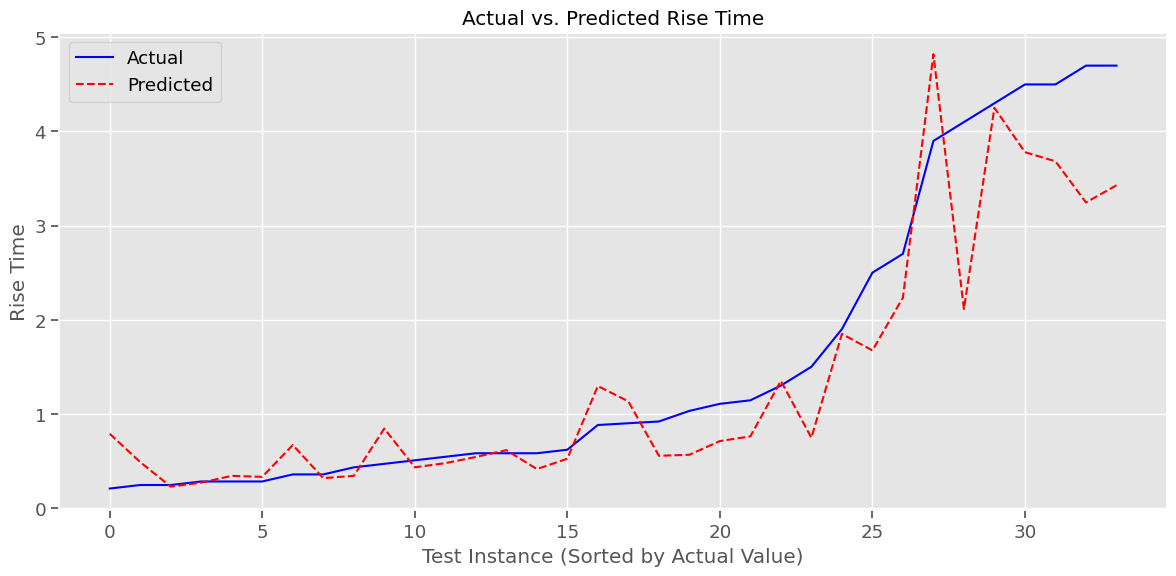

In [ ]:
# Create a dataframe with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_ann})

# Sort by actual values for better visualization
results_df = results_df.sort_values(by='Actual')

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'].values, 'b-', label='Actual')
plt.plot(results_df['Predicted'].values, 'r--', label='Predicted')
plt.title('Actual vs. Predicted Rise Time')
plt.xlabel('Test Instance (Sorted by Actual Value)')
plt.ylabel('Rise Time')
plt.legend()
plt.tight_layout()
plt.show()

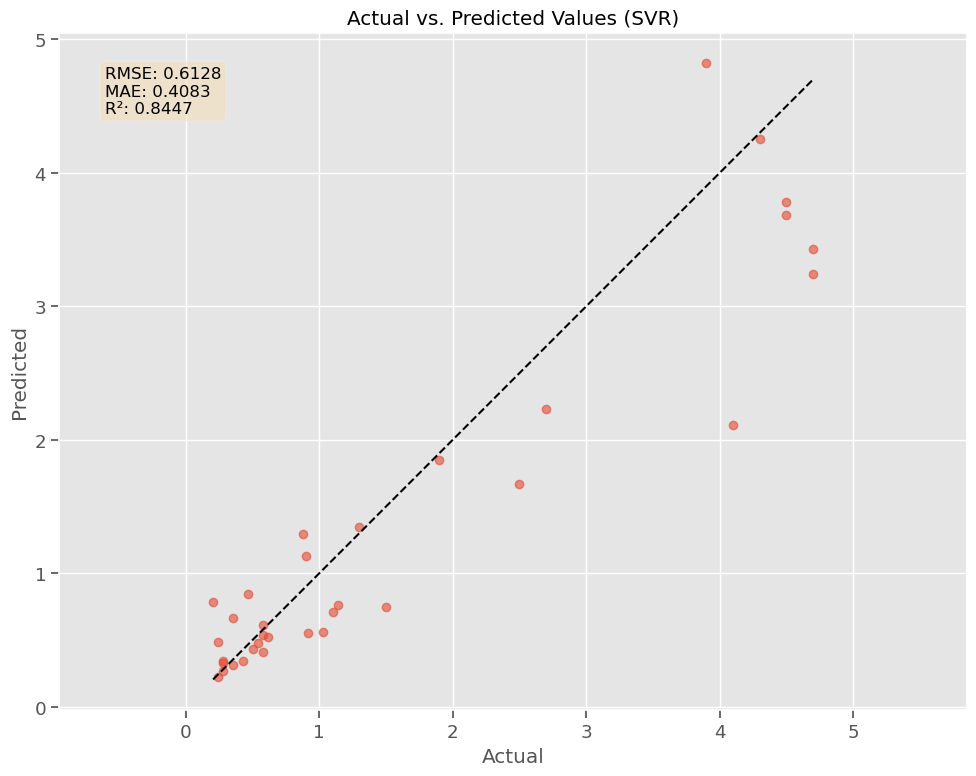

In [ ]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_ann, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (ANN)')

# Calculate the range for aspect ratio
range_actual = y_test.max() - y_test.min()
range_pred = y_pred_ann.max() - y_pred_ann.min()
plt.axis('equal')
plt.grid(True)

# Add text box with metrics
textstr = f'\n'.join((
    f'RMSE: {rmse_ann:.4f}',
    f'MAE: {mae_ann:.4f}',
    f'R²: {r2_ann:.4f}'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

### 5.2. Support Vector Regression Implementation

Let's implement the SVR model and optimize its hyperparameters using GridSearchCV.


In [ ]:
import time
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV

# Create the SVR pipeline
svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

# Define hyperparameter grid for SVR
param_grid = {
    'regressor__kernel': ['linear', 'rbf', 'poly'],
    'regressor__C': [0.01, 0.1, 1, 10, 100],
    'regressor__epsilon': [0.001, 0.01, 0.1, 0.2, 0.5],
    'regressor__gamma': ['scale', 'auto', 0.01, 0.1, 1.0],
    'regressor__degree': [2, 3],
    'regressor__coef0': [0.0, 1.0],
    'regressor__shrinking': [True, False]
}

# Print the total number of combinations
total_combinations = 3 * 5 * 5 * 5 * 2 * 2 * 2
print(f"Total parameter combinations: {total_combinations}")
print(f"Starting grid search at {datetime.now().strftime('%H:%M:%S')}")

# Choose which search method to use
use_randomized_search = True  # Set to False to use full grid search

if use_randomized_search:
    # Use RandomizedSearchCV for more efficient search
    print("Using RandomizedSearchCV with 100 iterations instead of full grid search")
    start_time = time.time()
    
    search = RandomizedSearchCV(
        svr_pipeline,
        param_distributions=param_grid,
        n_iter=100,  # Sample 100 parameter combinations
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=2,  # More verbose output
        n_jobs=-1,
        random_state=42
    )
else:
    # Use full GridSearchCV (may take a long time)
    print("Using full GridSearchCV with all parameter combinations")
    start_time = time.time()
    
    search = GridSearchCV(
        svr_pipeline,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=2,  # More verbose output
        n_jobs=-1
    )

# Fit the search
search.fit(X_train, y_train)

# Calculate and print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\nSearch completed at {datetime.now().strftime('%H:%M:%S')}")
print(f"Total execution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")

# Get the best parameters and best score
print("\nBest parameters:", search.best_params_)
print("Best cross-validation score: {:.4f}".format(-search.best_score_))

# Assign to grid_search for use in subsequent cells
grid_search = search

Total parameter combinations: 3000
Starting grid search at 01:42:34
Using RandomizedSearchCV with 100 iterations instead of full grid search
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END regressor__C=0.1, regressor__coef0=1.0, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.1, regressor__kernel=rbf, regressor__shrinking=True; total time=   0.0s
[CV] END regressor__C=10, regressor__coef0=0.0, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=linear, regressor__shrinking=False; total time=   0.1s
[CV] END regressor__C=0.1, regressor__coef0=1.0, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.1, regressor__kernel=rbf, regressor__shrinking=True; total time=   0.0s
[CV] END regressor__C=0.1, regressor__coef0=1.0, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.1, regressor__kernel=rbf, regressor__shrinking=True; total time=   0.0s
[CV] END regressor__C=10, regressor__coef0=0.0, r

In [ ]:
# Get the best model
best_svr = grid_search.best_estimator_

# Make predictions on the test set
y_pred_svr = best_svr.predict(X_test)
tr_y_pred_svr = best_svr.predict(X_train)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
r2_tr = r2_score(y_train, tr_y_pred_svr)

print(f"Mean Squared Error: {mse_svr:.4f}")
print(f"Root Mean Squared Error: {rmse_svr:.4f}")
print(f"Mean Absolute Error: {mae_svr:.4f}")
print(f"Test R² Score: {r2_svr:.4f}")
print(f"TRain R² Score: {r2_tr:.4f}")

Mean Squared Error: 0.1122
Root Mean Squared Error: 0.3349
Mean Absolute Error: 0.2722
Test R² Score: 0.9536
TRain R² Score: 0.8895


#### Visualizing Model Performance

Let's visualize how well our model predictions match the actual values.


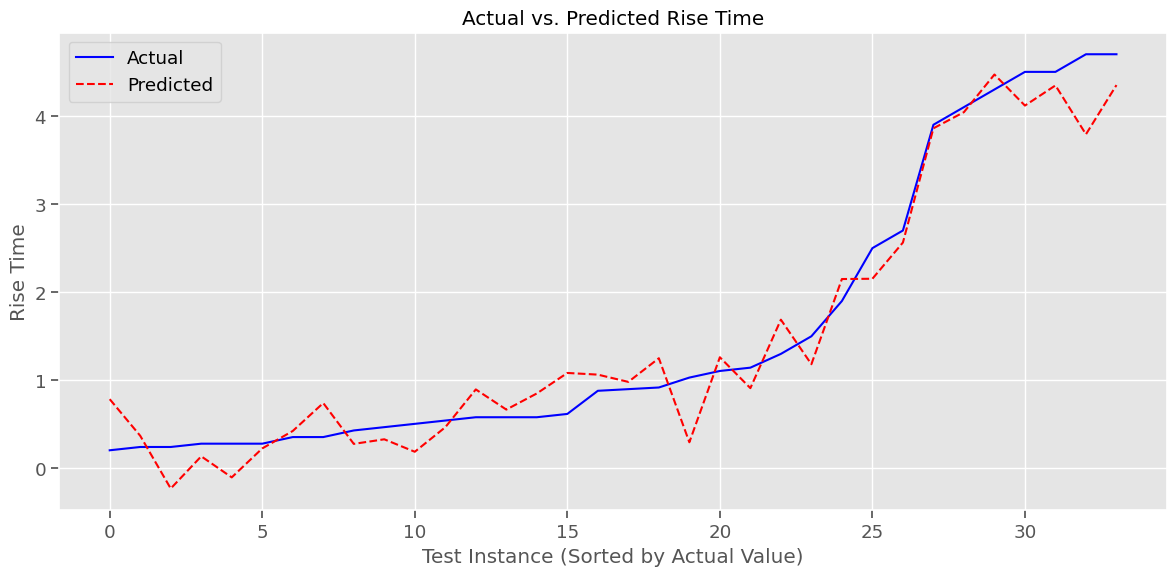

In [ ]:
# Create a dataframe with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svr})

# Sort by actual values for better visualization
results_df = results_df.sort_values(by='Actual')

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'].values, 'b-', label='Actual')
plt.plot(results_df['Predicted'].values, 'r--', label='Predicted')
plt.title('Actual vs. Predicted Rise Time')
plt.xlabel('Test Instance (Sorted by Actual Value)')
plt.ylabel('Rise Time')
plt.legend()
plt.tight_layout()
plt.show()

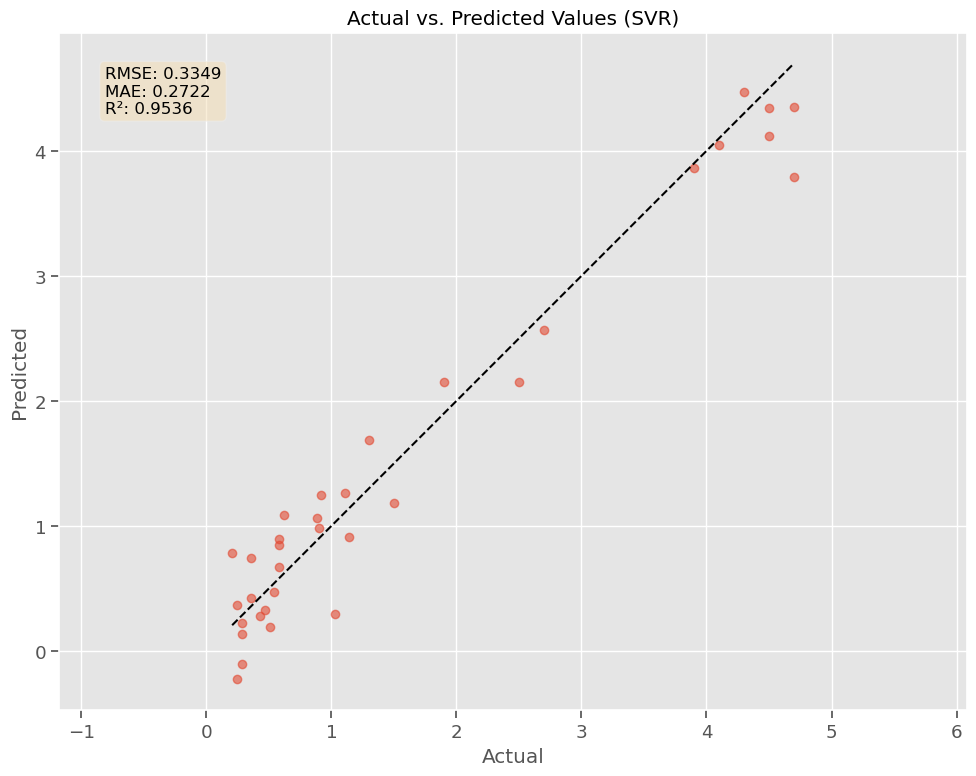

In [ ]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_svr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (SVR)')

# Calculate the range for aspect ratio
range_actual = y_test.max() - y_test.min()
range_pred = y_pred_svr.max() - y_pred_svr.min()
plt.axis('equal')
plt.grid(True)

# Add text box with metrics
textstr = f'\n'.join((
    f'RMSE: {rmse_svr:.4f}',
    f'MAE: {mae_svr:.4f}',
    f'R²: {r2_svr:.4f}'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

### 5.3. Linear & Quadratic Regression Implementation


First, let's see which degree of the polynomial is the best fit, using Leave One Out cross validation approach, since the size of the dataset is small (167 instances)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error


def choose_best_polynomial_degree(X_train, y_train, degrees=[1, 2, 3], k=10, random_state=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    avg_rmse_per_degree = {}

    y_train_array = np.asarray(y_train)

    for degree in degrees:
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X_train)
        rmse_list = []

        for train_index, val_index in kf.split(X_poly):
            X_tr, X_val = X_poly[train_index], X_poly[val_index]
            y_tr, y_val = y_train_array[train_index], y_train_array[val_index]

            model = LinearRegression()
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            rmse = root_mean_squared_error(y_val, y_pred)
            rmse_list.append(rmse)

        avg_rmse = np.mean(rmse_list)
        avg_rmse_per_degree[degree] = avg_rmse
        print(f"Degree {degree}: 10-Fold CV Avg RMSE = {avg_rmse:.4f}")

    best_degree = min(avg_rmse_per_degree, key=avg_rmse_per_degree.get)
    print(f"\nBest degree based on 10-Fold CV: {best_degree}")
    return best_degree



In [ ]:
best_deg = choose_best_polynomial_degree(X_train_processed, y_train)


Degree 1: 10-Fold CV Avg RMSE = 1.1625
Degree 2: 10-Fold CV Avg RMSE = 1.0448
Degree 3: 10-Fold CV Avg RMSE = 448.3483

Best degree based on 10-Fold CV: 2


As you can see, The best fit is the quadratic fit, it is slightly better than the linear fit which underfits the data


In [ ]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_processed)
X_test_poly = poly.transform(X_test_processed)

# Fit linear regression on polynomial features
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict on validation set
y_pred_quad = model.predict(X_test_poly)
tr_y_pred_quad = best_svr.predict(X_train)

# Evaluate the model
mse_quad = mean_squared_error(y_test, y_pred_quad)
rmse_quad = np.sqrt(mse_quad)
mae_quad = mean_absolute_error(y_test, y_pred_quad)
r2_quad = r2_score(y_test, y_pred_quad)
r2_tr = r2_score(y_train, tr_y_pred_quad)

print(f"Mean Squared Error: {mse_quad:.4f}")
print(f"Root Mean Squared Error: {rmse_quad:.4f}")
print(f"Mean Absolute Error: {mae_quad:.4f}")
print(f"Test R² Score: {r2_quad:.4f}")
print(f"TRain R² Score: {r2_tr:.4f}")

Mean Squared Error: 0.3269
Root Mean Squared Error: 0.5718
Mean Absolute Error: 0.4732
Test R² Score: 0.8648
TRain R² Score: 0.8895


We can see that our model is generalizable, since the R2 score of the training set is approximate to R2 score of the test set.


#### Visualizing Model Performance


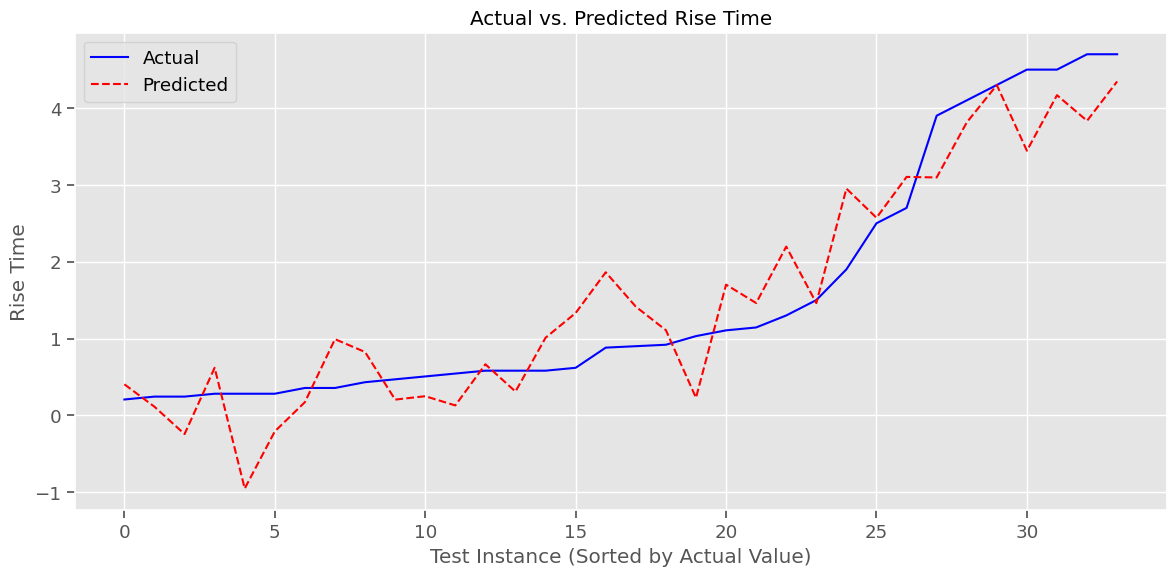

In [ ]:
# Create a dataframe with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_quad})

# Sort by actual values for better visualization
results_df = results_df.sort_values(by='Actual')

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'].values, 'b-', label='Actual')
plt.plot(results_df['Predicted'].values, 'r--', label='Predicted')
plt.title('Actual vs. Predicted Rise Time')
plt.xlabel('Test Instance (Sorted by Actual Value)')
plt.ylabel('Rise Time')
plt.legend()
plt.tight_layout()
plt.show()

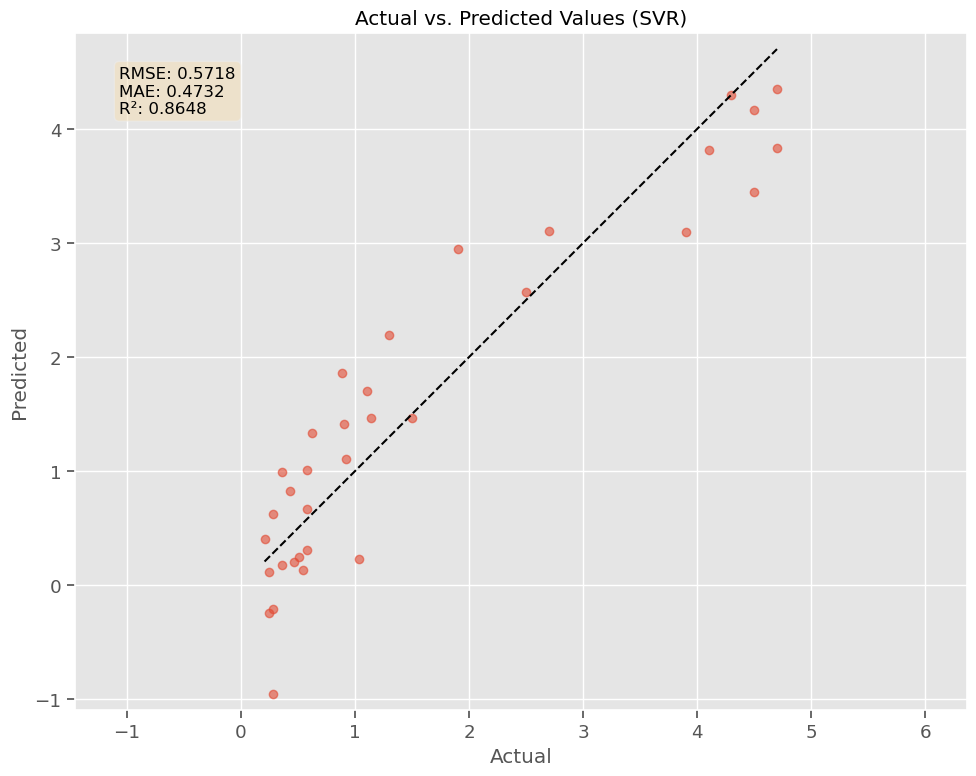

In [ ]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_quad, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Quadratic regression)')

# Calculate the range for aspect ratio
range_actual = y_test.max() - y_test.min()
range_pred = y_pred_quad.max() - y_pred_quad.min()
plt.axis('equal')
plt.grid(True)

# Add text box with metrics
textstr = f'\n'.join((
    f'RMSE: {rmse_quad:.4f}',
    f'MAE: {mae_quad:.4f}',
    f'R²: {r2_quad:.4f}'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

## 5.4 RandomForest and XGBoost models


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

getting best parameters for the random forest model


In [ ]:

grid_params = {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2']
}
rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=grid_params, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search_rf.fit(BX_train, y_train)

c:\Users\Bilal\anaconda3\envs\DM_env\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 250, 300]},
             scoring='neg_mean_squared_error')

In [ ]:
print("Best parameters for Random Forest:")
print(grid_search_rf.best_params_)

Best parameters for Random Forest:
{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}


getting the best parameters for XGBoost model


In [ ]:

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],               # Typical values for boosting
    'learning_rate': [0.01, 0.1, 0.3],     # Boosting step size
    'subsample': [0.6, 0.8, 1.0],          # Row sampling
    'colsample_bytree': [0.6, 0.8, 1.0]    # Feature sampling
}

xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')  # 'reg:squarederror' for regression

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                               cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search_xgb.fit(BX_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [ ]:
print("Best parameters for XGBoost:")
print(grid_search_xgb.best_params_)


Best parameters for XGBoost:
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.6}


## Evaluation of the model


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Get best models
best_rf = grid_search_rf.best_estimator_
best_xgb = grid_search_xgb.best_estimator_

# Predict
y_pred_rf = best_rf.predict(BX_test)
y_pred_xgb = best_xgb.predict(BX_test)

# Evaluation Function
def evaluate_model(y_true, y_pred, name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"📊 Evaluation for {name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  R²  : {r2:.4f}\n")


In [ ]:
sorted_y  = y_test.sort_values
sorted_y

<bound method Series.sort_values of 101    4.499986
108    0.431252
78     4.699995
56     0.881255
98     4.099967
29     4.299977
105    0.243751
82     0.468752
104    0.243751
109    2.499982
19     0.206250
42     0.918755
15     1.899990
67     1.299997
24     0.581253
31     3.899964
132    0.281251
51     4.499986
160    2.699979
16     0.900001
76     0.281251
18     0.543753
12     0.281251
9      1.031254
133    0.356251
75     0.506252
136    0.618753
60     0.581253
55     1.143746
147    1.499995
30     0.356251
141    1.106248
120    0.581253
148    4.699995
Name: class, dtype: float64>

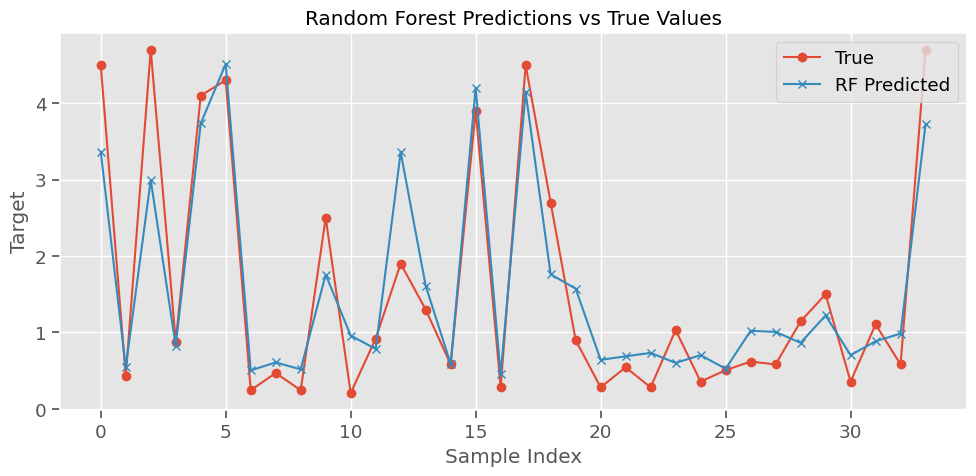

📊 Evaluation for Random Forest:
  RMSE: 0.5926
  MAE : 0.4468
  R²  : 0.8548



In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="True", marker='o')
plt.plot(y_pred_rf, label="RF Predicted", marker='x')
plt.legend()
plt.title("Random Forest Predictions vs True Values")
plt.xlabel("Sample Index")
plt.ylabel("Target")
plt.grid(True)
plt.tight_layout()
plt.show()


# Evaluate 
evaluate_model(y_test, y_pred_rf, "Random Forest")

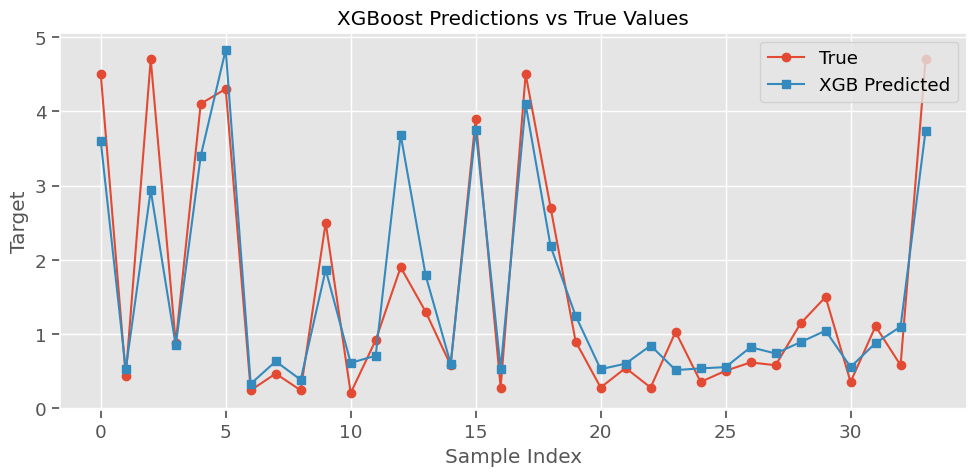

📊 Evaluation for XGBoost:
  RMSE: 0.5877
  MAE : 0.4185
  R²  : 0.8572



In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="True", marker='o')
plt.plot(y_pred_xgb, label="XGB Predicted", marker='s')
plt.legend()
plt.title("XGBoost Predictions vs True Values")
plt.xlabel("Sample Index")
plt.ylabel("Target")
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate 
evaluate_model(y_test, y_pred_xgb, "XGBoost")



## Feature importance


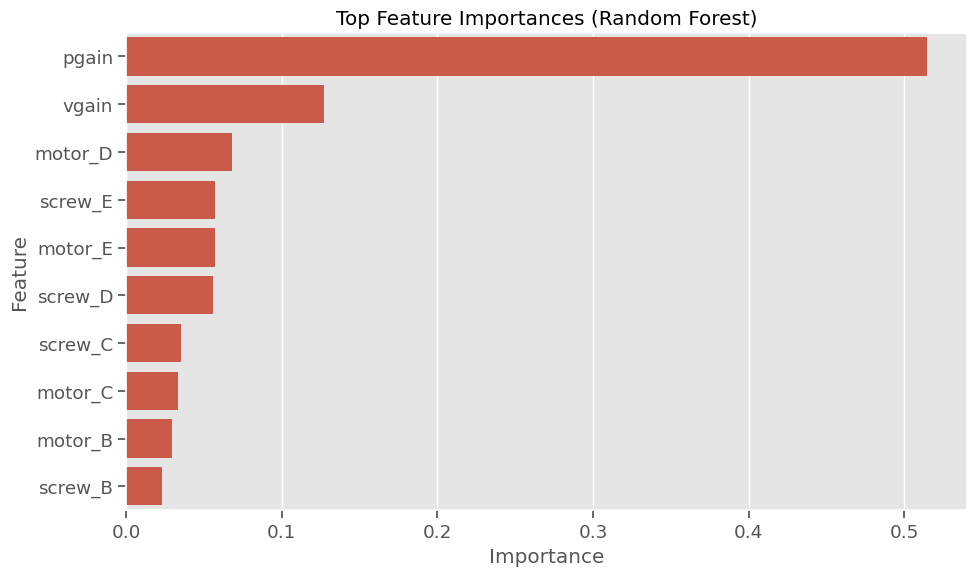

In [ ]:
importances = best_rf.feature_importances_
feature_names = BX.columns
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(20))  # Top 20 features
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


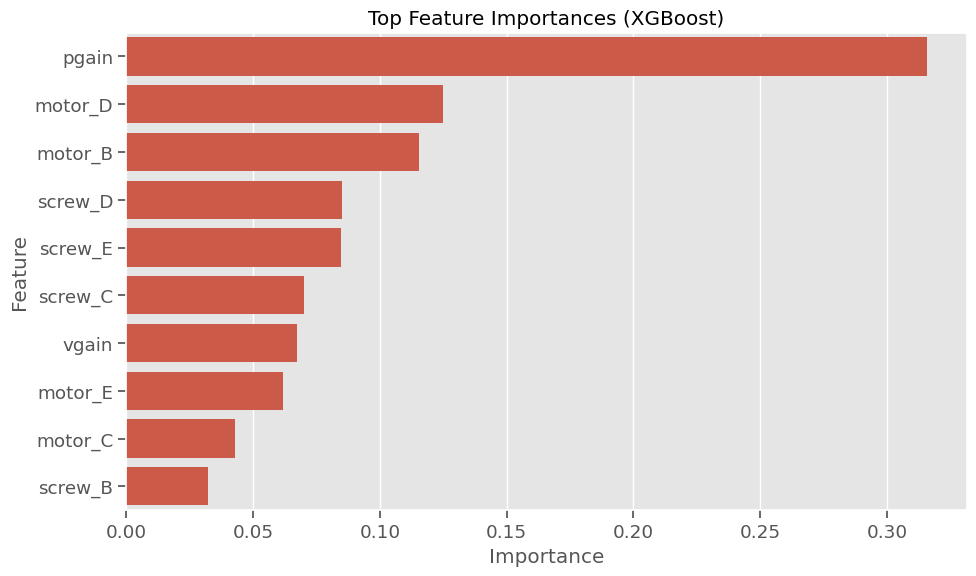

In [ ]:
importances = best_xgb.feature_importances_
feature_names = BX.columns
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(20))  # Top 20 features
plt.title("Top Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import cross_val_score

# Standardize features (important for KNN)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(BX_train)
# X_test_scaled = scaler.transform(BX_test)


In [26]:
#  Initial Model to get a baseline
knn = KNeighborsRegressor()
knn.fit(BX_train, y_train)
y_pred = knn.predict(BX_test)

In [27]:
# Evaluate the baseline
print("Initial Model Evaluation:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")


Initial Model Evaluation:
RMSE: 0.8436
MAE: 0.6240
R²: 0.7058


In [28]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 (Manhattan), p=2 (Euclidean)
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, 
                           cv=5, scoring='neg_root_mean_squared_error', 
                           n_jobs=-1, verbose=1)
grid_search.fit(BX_train, y_train)

# Best Parameters
print("\nBest Parameters Found:")
print(grid_search.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best Parameters Found:
{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [29]:
# Evaluate Best Model
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(BX_test)

print("\nBest Model Evaluation:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_best):.4f}")
print(f"R²: {r2_score(y_test, y_pred_best):.4f}")



Best Model Evaluation:
RMSE: 0.8436
MAE: 0.6240
R²: 0.7058


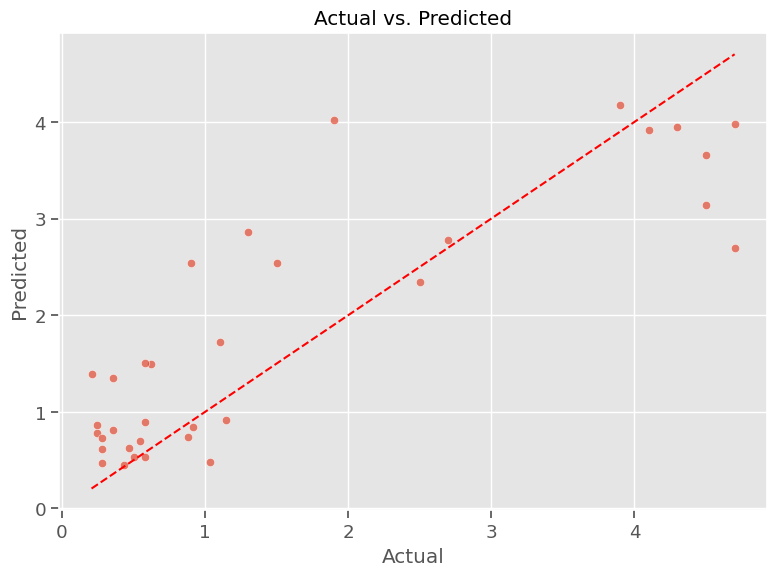


Cross-validated RMSE: 0.9949 ± 0.1988


In [31]:
# Optional: Visual Evaluation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

#  Cross-validated RMSE of best model
cv_rmse = -cross_val_score(best_knn, BX_train, y_train, 
                           cv=5, scoring='neg_root_mean_squared_error')
print(f"\nCross-validated RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

## 6.Model comparison


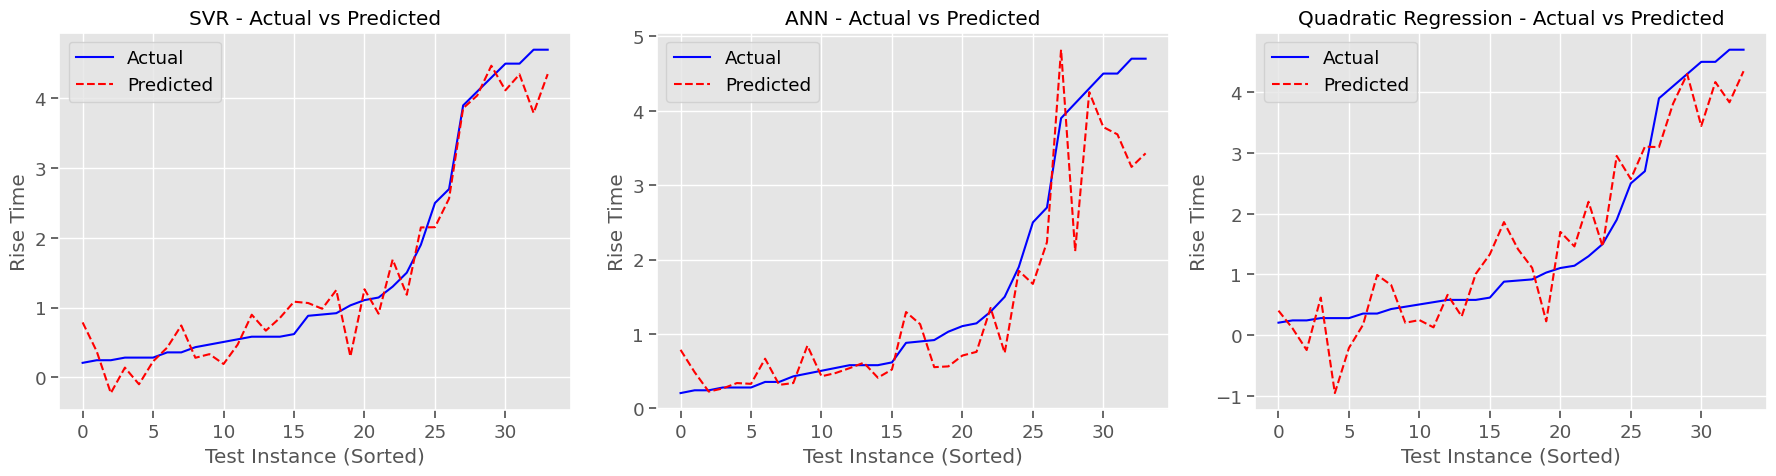

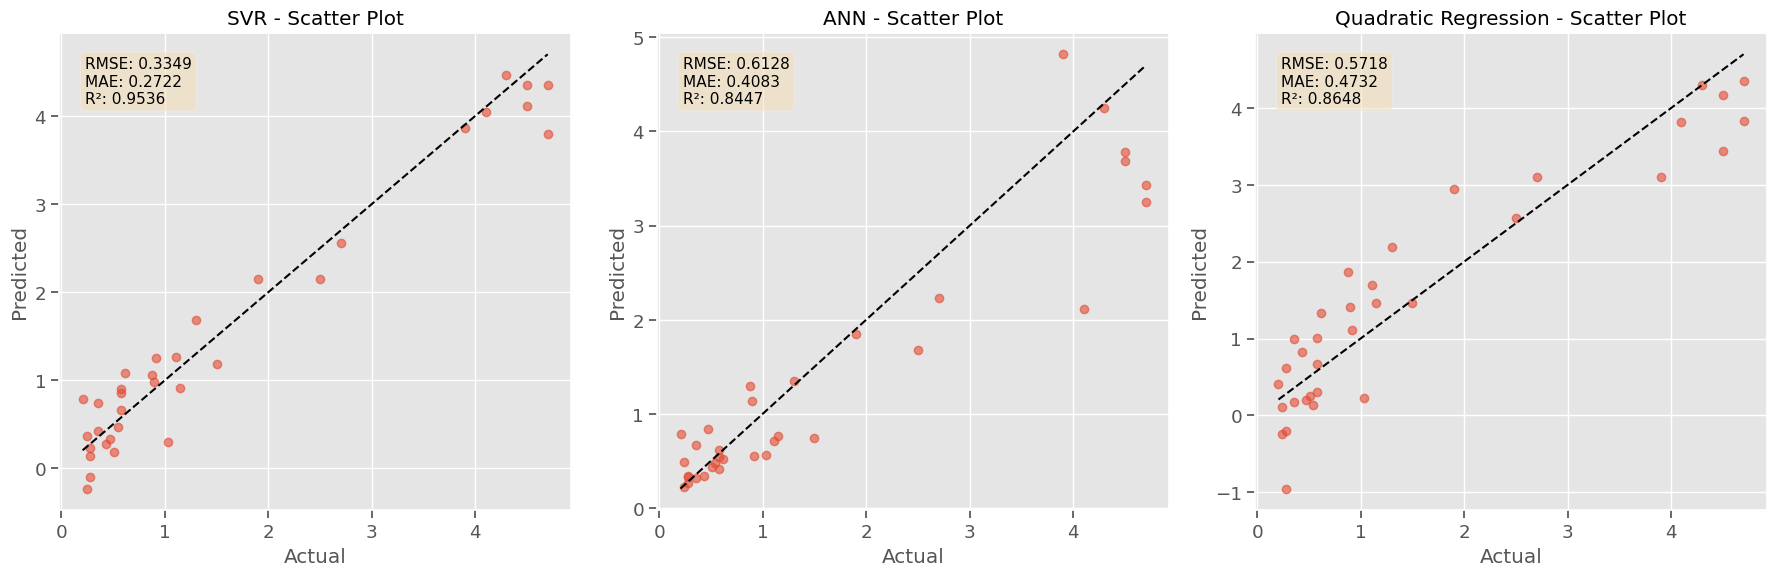

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Model names and predictions
models = ['SVR', 'ANN', 'Quadratic Regression']
predictions = [y_pred_svr, y_pred_ann, y_pred_quad]
metrics = [
    (rmse_svr, mae_svr, r2_svr),
    (rmse_ann, mae_ann, r2_ann),
    (rmse_quad, mae_quad, r2_quad)
]

# Create subplots for line plots (1 row, 3 columns)
plt.figure(figsize=(18, 5))
for i, (model, y_pred) in enumerate(zip(models, predictions)):
    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    results_df = results_df.sort_values(by='Actual')

    plt.subplot(1, 3, i+1)
    plt.plot(results_df['Actual'].values, 'b-', label='Actual')
    plt.plot(results_df['Predicted'].values, 'r--', label='Predicted')
    plt.title(f'{model} - Actual vs Predicted')
    plt.xlabel('Test Instance (Sorted)')
    plt.ylabel('Rise Time')
    plt.legend()
    plt.tight_layout()

plt.show()

# Create subplots for scatter plots
plt.figure(figsize=(18, 6))
for i, (model, y_pred, (rmse, mae, r2)) in enumerate(zip(models, predictions, metrics)):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{model} - Scatter Plot')

    # Add metrics box
    textstr = '\n'.join((
        f'RMSE: {rmse:.4f}',
        f'MAE: {mae:.4f}',
        f'R²: {r2:.4f}'
    ))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=11,
             verticalalignment='top', bbox=props)
    plt.grid(True)

plt.tight_layout()
plt.show()


## 7. Residual Analysis

Let's analyze the residuals (prediction errors) to check for patterns or bias in our models.


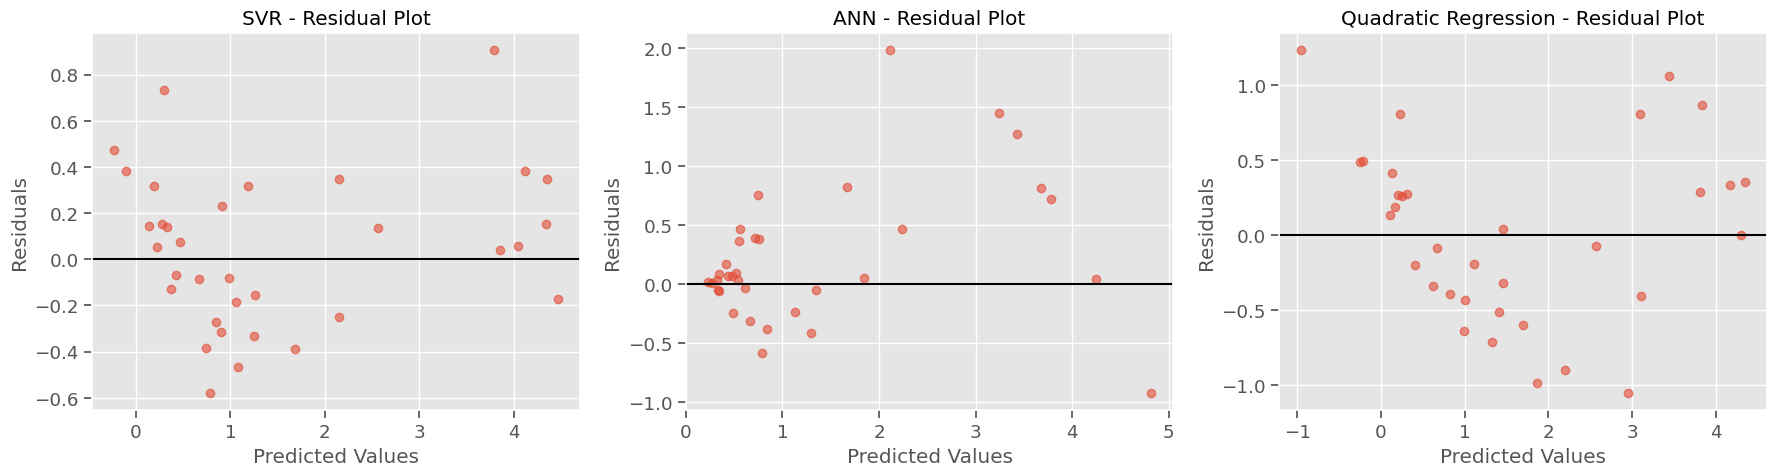

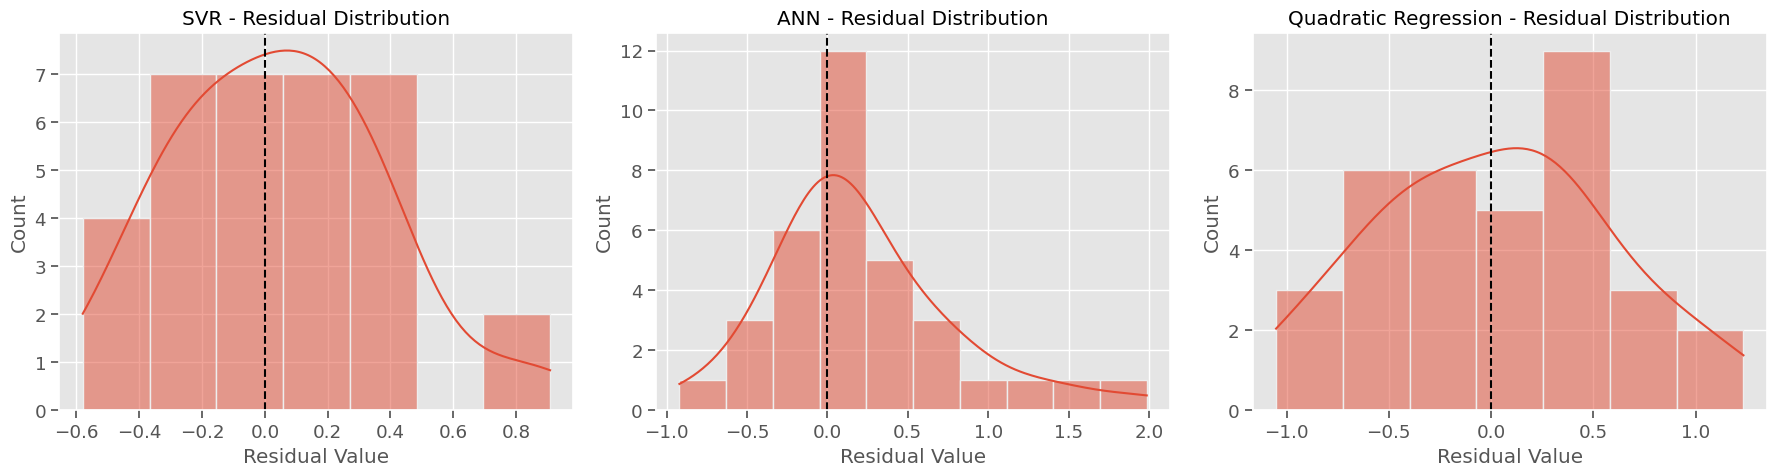

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Model predictions and names
models = ['SVR', 'ANN', 'Quadratic Regression']
predictions = [y_pred_svr, y_pred_ann, y_pred_quad]

# Residual Plot
plt.figure(figsize=(18, 5))
for i, (model, y_pred) in enumerate(zip(models, predictions)):
    residuals = y_test - y_pred
    plt.subplot(1, 3, i+1)
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.title(f'{model} - Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Residual Distribution Plot
plt.figure(figsize=(18, 5))
for i, (model, y_pred) in enumerate(zip(models, predictions)):
    residuals = y_test - y_pred
    plt.subplot(1, 3, i+1)
    sns.histplot(residuals, kde=True)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.title(f'{model} - Residual Distribution')
    plt.xlabel('Residual Value')

plt.tight_layout()
plt.show()


## 8. Feature Importance Analysis

Let's try to understand which features are most important for our SVR model. For non-linear kernels like RBF, direct feature importance is not available, but we can use a linear kernel to get some insights.


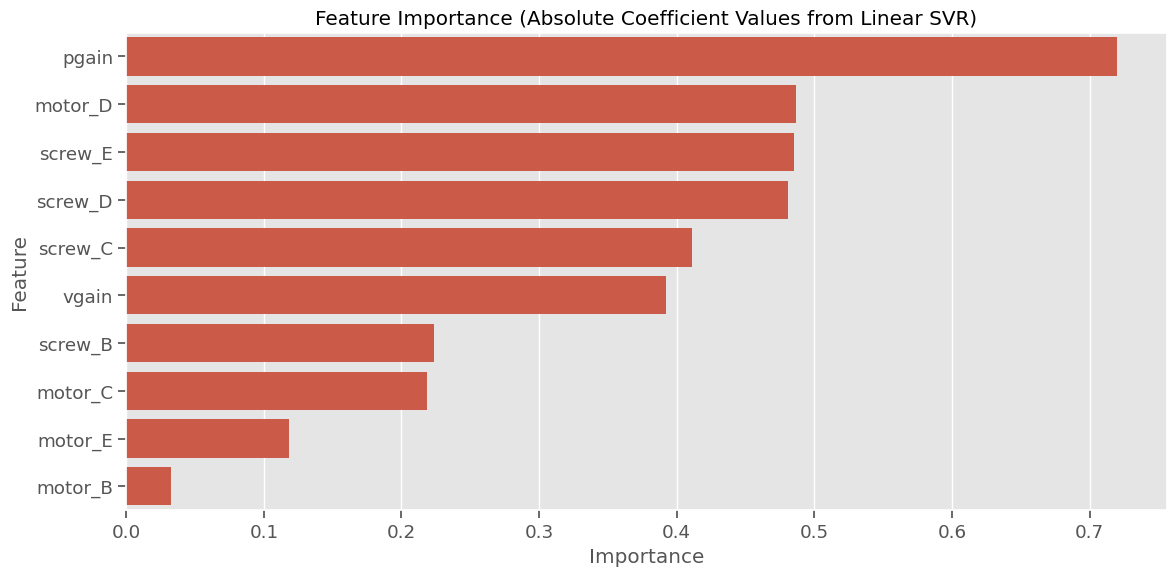

In [ ]:
# Create a linear SVR to analyze feature importance
linear_svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='linear', C=1.0))
])

# Train the model
linear_svr_pipeline.fit(X_train, y_train)

# Extract feature importances (coefficients) from the linear SVR
linear_svr = linear_svr_pipeline.named_steps['regressor']
feature_importances = linear_svr.coef_[0]

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': np.abs(feature_importances)
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance (Absolute Coefficient Values from Linear SVR)')
plt.tight_layout()
plt.show()

## 9. Conclusion and Model Summary

Our SVR model has been trained and evaluated on the servo dataset. Here's a summary of the findings:


Support Vector Regression Model Summary
----------------------------------------
Best Parameters: {'regressor__shrinking': False, 'regressor__kernel': 'rbf', 'regressor__gamma': 0.1, 'regressor__epsilon': 0.1, 'regressor__degree': 3, 'regressor__coef0': 0.0, 'regressor__C': 100}
Cross-Validation RMSE: 0.7949
Test Set RMSE: 0.5718
Test Set MAE: 0.4732
Test Set R²: 0.8648
----------------------------------------

Comparison with other methods:
                    Method  Relative Error
0            Guessing mean        1.000000
1           Instance-based        0.260000
2               Regression        0.490000
3              Model trees        0.290000
4  Neural nets (G. Hinton)        0.110000
5     Regression+instances        0.200000
6    Model trees+instances        0.170000
7             NN+instances        0.110000
8            Our SVR model        0.411496


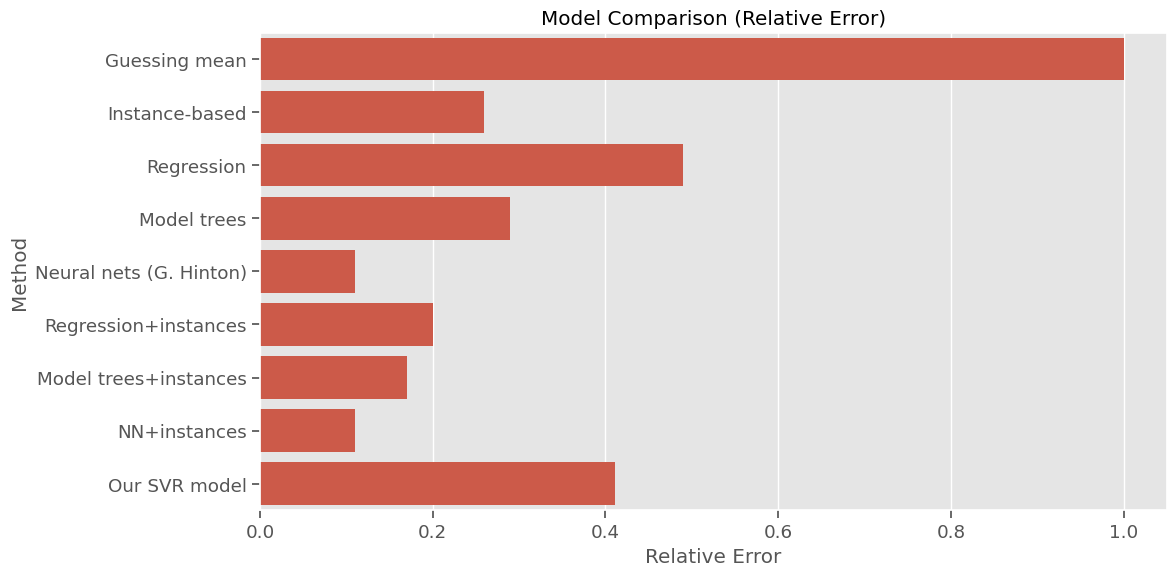

In [ ]:
# Print a summary of model performance
print("Support Vector Regression Model Summary")
print("-" * 40)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Cross-Validation RMSE: {np.sqrt(-grid_search.best_score_):.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set R²: {r2:.4f}")
print("-" * 40)

# Compare with the other methods mentioned in the dataset description
methods = [
    'Guessing mean', 'Instance-based', 'Regression', 'Model trees', 
    'Neural nets (G. Hinton)', 'Regression+instances', 'Model trees+instances', 
    'NN+instances', 'Our SVR model'
]
relative_errors = [1.00, 0.26, 0.49, 0.29, 0.11, 0.20, 0.17, 0.11, None]  # Our SVR error will be calculated

# Calculate our model's relative error (assume guessing mean would give a MAE of 1.15)
# This is just an approximation since we don't have the exact same test set
our_relative_error = mae / 1.15
relative_errors[-1] = our_relative_error

# Create dataframe for comparison
comparison_df = pd.DataFrame({
    'Method': methods,
    'Relative Error': relative_errors
})

print("\nComparison with other methods:")
print(comparison_df)

# Plot the comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Relative Error', y='Method', data=comparison_df)
plt.title('Model Comparison (Relative Error)')
plt.tight_layout()
plt.show()

##
